Let us consider a system of $N$ agents, each agent $i$
characterized by a dynamic opinion variable $x_i(t)$. For
the sake of simplicity, we consider opinions to be one dimensional,
with $x_i \in [-\infty;+\infty]$. The sign of the opinion
$x_i$, $\sigma(x_i)$, describes the agent's qualitative stance towards
 a binary issue of choice, such as the preference
between two candidates or a pro/con attitude in a controversial
topic. The absolute value of $x_i$, $|x_i|$, describes
the opinion's strength, or conviction, with respect to one
of the sides: the larger $|x_i|$, the more extreme the opinion
of agent $i$.

## Imports and settings

In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import powerlaw
from scipy.integrate import solve_ivp
from opdynamics.echochamber import EchoChamber
from opdynamics.visualise import VisEchoChamber

np.random.seed(1337)

## Parameters

In [2]:
num_agents = 1000
m = 10  # number of other agents to interact with
alpha = 0.05  # controversialness of issue (sigmoidal shape)
K = 3  # social interaction strength
eta = 1e-2  # minimum activity level with another agent
gamma = 2.1  # power law distribution param
beta = 2  # power law decay of connection probability
activity_distribution = powerlaw

## Variables

In [3]:
ec = EchoChamber(num_agents, m, K, alpha)
vis = VisEchoChamber(ec)

## Set activity based on powerlaw distribution

$$ F(a) = a^{-\gamma} \tag{1}$$

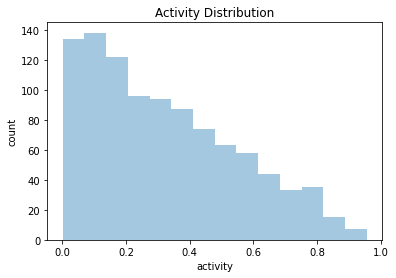

In [4]:
ec.set_activities(activity_distribution, gamma, eta, 1, inverse=True)
vis.show_activities()

## Connection probabilities

$$ p_{ij} = \frac{|x_i - x_j|^{-\beta}}{\sum_j |x_i - x_j|^{-\beta}} \tag{2}$$

In [5]:
ec.set_connection_probabilities(beta=beta)

## Dynamics


Assuming that the opinion dynamics is solely
driven by the interactions among agents, we formulate
the model as $N$ coupled ordinary differential equations,

$$ \dot{x_i} = -x_i + K \sum_{j=1}^{N} A_{ij}(t) \tanh(\alpha x_j) \tag{3}$$

where K > 0 denotes the social interaction strength
among agents and $\alpha$ determines the sigmoidal shape of
the hyperbolic tangent. The opinion of an agent $i$ follows
the aggregated social input from the set of his/her neighbors
at time $t$, determined by the symmetric adjacency
matrix of the temporal network $A_{ij}(t)$, where $A_{ij}(t) = 1$
if agents $i$ and $j$ are interacting at time $t$, $A_{ij}(t) = 0$
otherwise. A similar model with static connectivity has
previously been used to describe the dynamics of neural
networks showing a transition from stationary to chaotic
phase [30].
The parameter $\alpha > 0$ tunes the degree of non-linearity
between an agent's opinion and the social influence s/he exerts on others.

In [6]:
ec.set_dynamics()

## Run and plot results

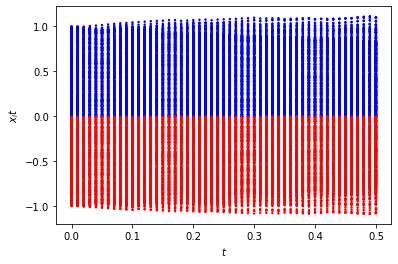

In [7]:
ec.run_network(dt=0.01, t_end=0.5)
vis.show_opinions(color_code=True)

In [8]:
# General params

N=1000
m=10
T=5
eta=1e-2
gamma=2.1

# Specific params for different dynamics
param_set={
    "neutral": dict(K=3,alpha=0.05,beta=2),
    "radical": dict(K=3,alpha=3,beta=0),
    "polar": dict(K=3,alpha=3,beta=3)
    }

## Neutral opinion

- $K = 3$
- $\alpha = 0.05$
- $beta = 2$

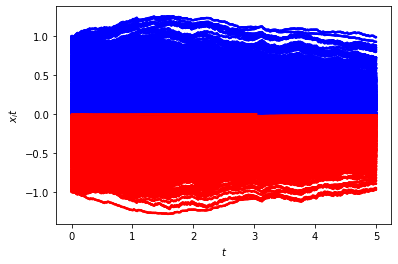

In [10]:
EchoChamber.run_params(N=N,m=m,**param_set['neutral'],
           eta=eta,gamma=gamma,
           dt=0.01, T=T,
           mutual_interactions=True,
           plot_opinion=True)

## Radicalisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 0$

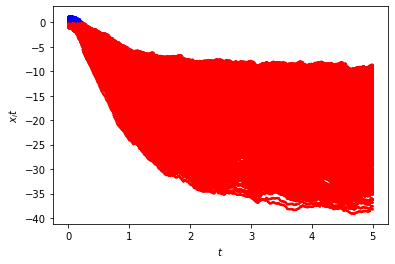

In [11]:
EchoChamber.run_params(N=N,m=m,**param_set['radical'],
           eta=eta,gamma=gamma,
           dt=0.01, T=T,
           mutual_interactions=True,
           plot_opinion=True)

## Polarisation of opinions

- $K = 3$
- $\alpha = 3$
- $beta = 3$

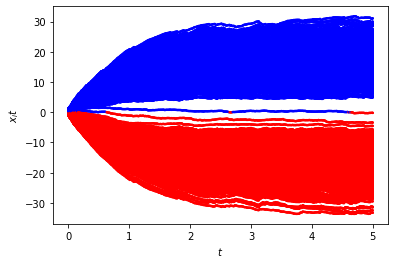

In [12]:
EchoChamber.run_params(N=N,m=m,**param_set['polar'],
           eta=eta,gamma=gamma,
           dt=0.01, T=T,
           mutual_interactions=True,
           plot_opinion=True)